## Check if all ~300k original sequences can be detected using full index

In [1]:
palmdb = "/home/laura/projects/virus-watch-data/virus_ref/uniques_noduplicates.fa"
virus_t2g = "/home/laura/projects/virus-watch-data/virus_ref/nodup_clu_t2g.txt"

# Files generated in this notebook
virus_index = "/home/laura/projects/virus-watch-data/virus_ref/testing/index.idx"
out_folder = "/home/laura/projects/virus-watch-data/virus_ref/testing"
palmdb_nn_fasta = "/home/laura/projects/virus-watch-data/virus_ref/testing/uniques_nn.fasta"
# palmdb_nn_fastq = "/home/laura/projects/virus-watch-data/virus_ref/testing/uniques_nn.fastq"
sample = "all_vs_all"

kallisto = "/home/laura/projects/kallisto/build/src/kallisto"
bustools = "/home/laura/projects/bustools/build/src/bustools"

In [48]:
# Generate virus reference index
!/usr/bin/time -v $kallisto index \
    -t 32 \
    --aa \
    -i $virus_index \
    $palmdb


[build] loading fasta file /home/laura/projects/virus-watch-data/virus_ref/uniques_noduplicates.fa
[build] k-mer length: 31
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Finished
CompactedDBG::build(): Estimated number of k-mers occurring at least once: 37641510
CompactedDBG::build(): Estimated number of minimizer occurring at least once: 7877811
CompactedDBG::filter(): Processed 87630084 k-mers in 296561 reads
CompactedDBG::filter(): Found 37509064 unique k-mers
CompactedDBG::filter(): Number of blocks in Bloom filter is 257317
CompactedDBG::construct(): Extract approximate unitigs (1/2)
CompactedDBG::construct(): Extract approximate unitigs (2/2)
CompactedDBG::construct(): Closed all input files

CompactedDBG::construct(): Splitting unitigs (1/2)

CompactedDBG::construct(): Splitting unitigs (2/2)
CompactedDBG::construct(): Before split: 2040473 uni

Reverse translate virus ref amino acid sequences to nucleotides:

In [2]:
# Adapted from https://github.com/Edinburgh-Genome-Foundry/DnaChisel
from Bio.Data import CodonTable

def flatten(l):
    return [item for sublist in l for item in sublist]

def get_backtranslation_table(table_name="Standard"):
    table = CodonTable.unambiguous_dna_by_name[table_name]
    back_translation_table = {}
    for codon, amino_acid in table.forward_table.items():
        if amino_acid not in back_translation_table:
            back_translation_table[amino_acid] = []
        back_translation_table[amino_acid].append(codon)
    back_translation_table["*"] = table.stop_codons
    back_translation_table["START"] = table.start_codons
    back_translation_table["X"] = list(set(flatten(back_translation_table.values())) - set(back_translation_table["*"]))
    back_translation_table["B"] = back_translation_table["N"] + back_translation_table["D"]
    back_translation_table["J"] = back_translation_table["L"] + back_translation_table["I"]
    back_translation_table["Z"] = back_translation_table["E"] + back_translation_table["Q"]
    return back_translation_table

def reverse_translate(protein_sequence, randomize_codons=False, table="Standard"):
    """Return a DNA sequence which translates to the provided protein sequence.

    Parameters
    ----------

    protein_sequence
      A sequence string of aminoacids, e.g. "MVKK..."

    table
      Genetic code table to use (e.g. 'Standard', 'Bacterial', etc.).
      See dnachisel.biotools.CODON_TABLE_NAMES for a list of available genetic
      code tables.

    randomize_codons
      If False, the first valid codon found is used for each, which can create
      biases (GC content, etc.), if True, each amino acid gets replaced by a
      randomly selected codon for this amino acid.
    """
    backtranslation_table = get_backtranslation_table(table_name=table)
    if randomize_codons:
        random_numbers = np.random.randint(0, 1000, len(protein_sequence))
        random_indices = [
            random_number % len(backtranslation_table[aa])
            for aa, random_number in zip(protein_sequence, random_numbers)
        ]
        return "".join(
            [
                backtranslation_table[aa][random_indice]
                for aa, random_indice in zip(protein_sequence, random_indices)
            ]
        )
    return "".join([backtranslation_table[aa][0] for aa in protein_sequence])

In [ ]:
# Reverse translate virus ref amino acid sequences to nucleotides and save to fasta
from Bio import SeqIO

with open(palmdb) as handle, open(palmdb_nn_fasta, "w") as palm_nuc:
    for record in SeqIO.parse(handle, "fasta"):
        palm_nuc.write(">" + str(record.id) + "\n")
        palm_nuc.write(reverse_translate(str(record.seq), table="Standard") + "\n")

In [ ]:
# # Use seqtk to transform fasta to fastq
# !/home/laura/projects/seqtk/seqtk seq -F '#' $palmdb_nn_fasta > $palmdb_nn_fastq

In [49]:
!/usr/bin/time -v $kallisto bus \
        -i $virus_index \
        -o $out_folder/$sample \
        --aa \
        -t 32 \
        $palmdb_nn_fasta \
        &> $out_folder/$sample/kb_out.txt 

!$bustools sort -o $out_folder/$sample/output_sorted.bus $out_folder/$sample/output.bus

!$bustools count \
    --genecounts \
    --cm -m \
    -o $out_folder/$sample/bustools_count/ \
    -g $virus_t2g \
    -e $out_folder/$sample/matrix.ec \
    -t $out_folder/$sample/transcripts.txt \
    $out_folder/$sample/output_sorted.bus

 all fits in buffer
Read in 286859 BUS records
reading time 0s
sorting time 0.04s
writing time 0.02s


In [3]:
# Load count matrix
import kb_python.utils as kb_utils

# Filepath to counts
X = f"{out_folder}/{sample}/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{out_folder}/{sample}/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{out_folder}/{sample}/bustools_count/output.barcodes.txt" 

# Create AnnData object
adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)
adata

/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)


AnnData object with n_obs × n_vars = 1 × 99228

In [4]:
# Load number of expected matches per representative sequence
import pandas as pd

u_tax = f"/home/laura/projects/virus-watch-data/virus_ref/u_tax_nodup_clu.csv"
# Load representative IDs and their members
rep_id_df = pd.read_csv(u_tax)
rep_id_df

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
296556,u296608,u296608,.,.,.,.,.,.,unknown
296557,u296609,u296609,.,.,.,.,.,.,unknown
296558,u296613,u296613,.,.,.,.,.,.,unknown
296559,u296616,u296616,.,.,.,.,.,.,unknown


In [6]:
%%time
counts = []
expected_counts = []
for virus_id in adata.var.index:
    counts.append(adata[:, adata.var.index==virus_id].X.sum())
    expected_counts.append(len(rep_id_df[rep_id_df["rep_ID"]==virus_id]))

CPU times: user 29min 25s, sys: 515 ms, total: 29min 26s
Wall time: 29min 26s


In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

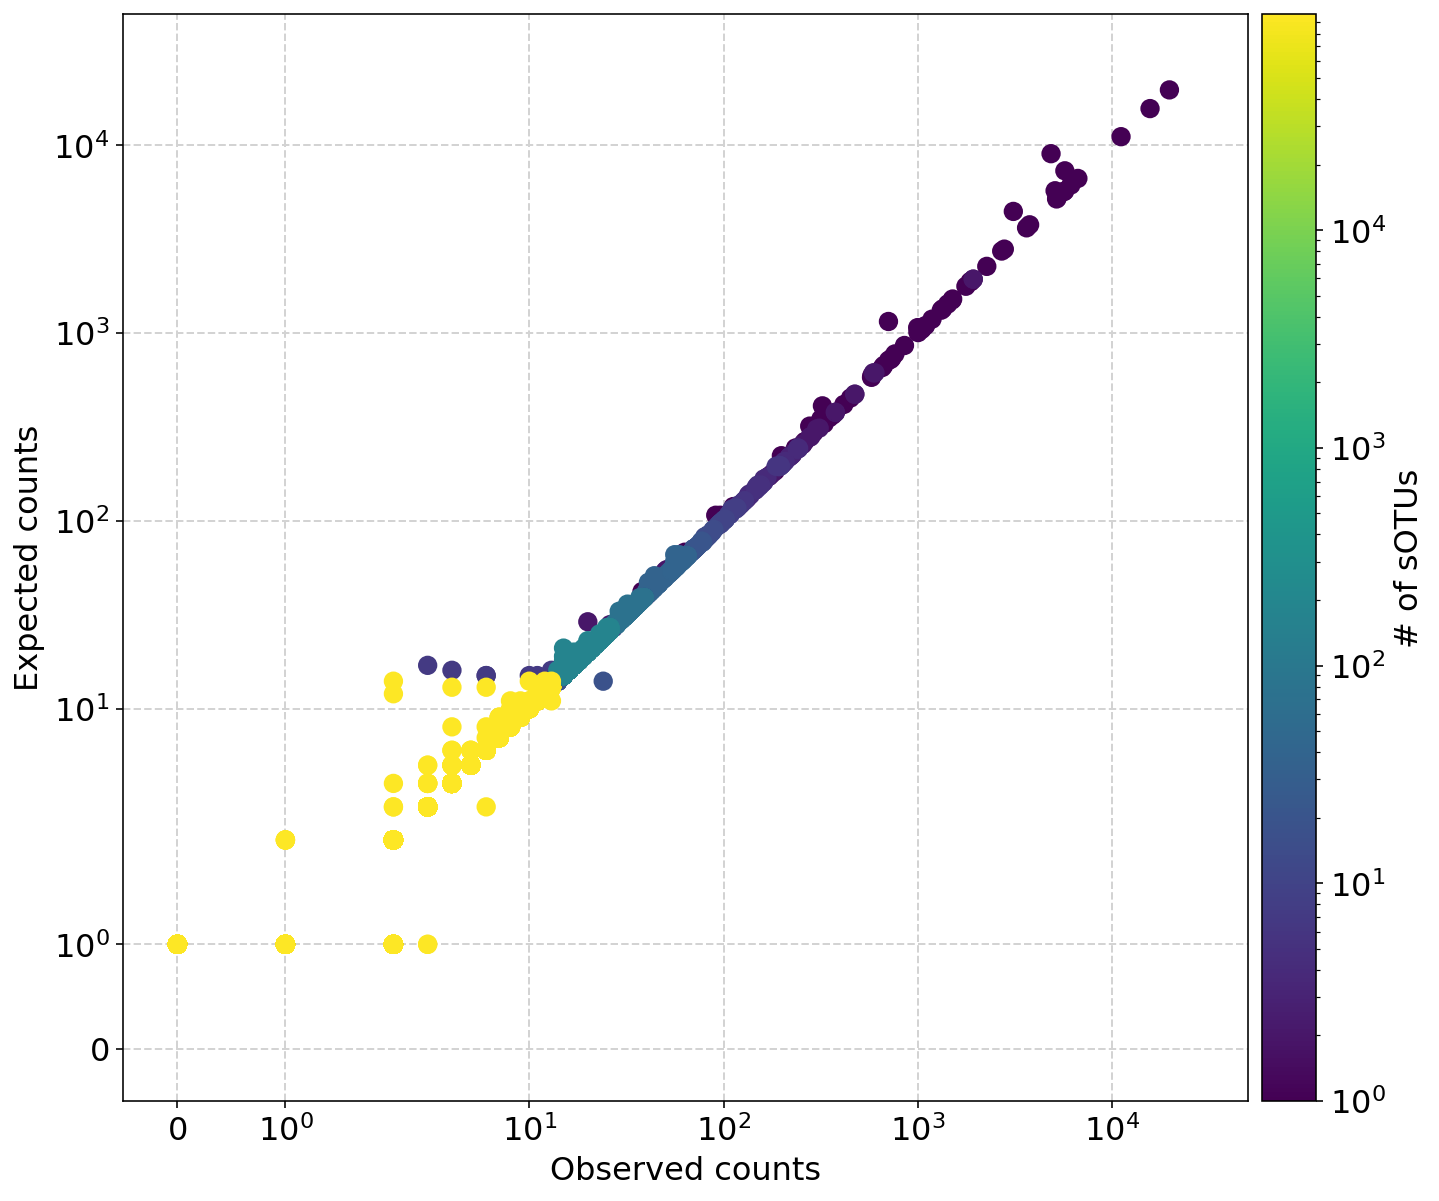

In [10]:
fig, ax = plt.subplots(figsize=(12,10))
fontsize = 16

x = np.array(counts)
y = np.array(expected_counts)

# Histogram data to show point density
bins = [1500, 1500]
hh, locx, locy = np.histogram2d(x, y, bins=bins)
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]
        
scatter = ax.scatter(x2, y2, c=z2, cmap="viridis", norm=matplotlib.colors.LogNorm(), s=75)

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.01)
cbar.ax.tick_params(axis="both", labelsize=fontsize)
cbar.ax.set_ylabel(f"# of sOTUs", fontsize=fontsize)

ax.set_ylim(bottom=-0.5, top=50000)
ax.set_xlim(left=-0.5, right=50000)

ax.set_yscale("symlog")
ax.set_xscale("symlog")

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

ax.tick_params(axis="both", labelsize=fontsize)
ax.set_ylabel("Expected counts", fontsize=fontsize)
ax.set_xlabel("Observed counts", fontsize=fontsize)

plt.savefig(f"figures/3.4_{sample}.png", dpi=300, bbox_inches="tight")

fig.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# %config InlineBackend.figure_format='retina'

# fig, ax = plt.subplots(figsize=(10,10))
# fontsize = 14

# # Plot how often each sequence in ref was seen
# unique, counts = np.unique(np.array(adata.X.todense())[0], return_counts=True)
# ax.bar(unique, counts)
# ax.set_xlabel("Observed count for one ID", fontsize=fontsize)
# ax.set_ylabel("Number of occurences", fontsize=fontsize)
# ax.set_yscale("symlog")

# # # Match x lim to GPT code
# # ax.set_xlim(left=-1, right=17)

# ax.margins(x=0.01)
# ax.tick_params(axis="both", labelsize=fontsize)

# plt.savefig(f"figures/3.4_{sample}_symlog.png", dpi=300, bbox_inches="tight")

# fig.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# %config InlineBackend.figure_format='retina'

# fig, ax = plt.subplots(figsize=(7,7))
# # Plot how often each sequence in ref was seen
# unique, counts = np.unique(np.array(adata.X.todense())[0], return_counts=True)
# ax.bar(unique, counts)
# ax.set_xlabel("Observed count for one ID")
# ax.set_ylabel("Number of occurences")

# ax.axhline(296623, c="black", ls="--", lw=1)

# plt.savefig(f"figures/3.4_{sample}.png", dpi=300, bbox_inches="tight")

# fig.show()